In [1]:
import glob
import os, sys

LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [263]:
config, cfn = crw.read(os.path.join(os.getcwd(), "config.neuron.mpra.ini"))
LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    MPRA = os.path.join(PATH, "delta_rank.csv")
    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")
    TILE_BED = os.path.join(PATH, "lib2.processed.bed")
    ENH_BED = os.path.join(PATH, 'lib2.processed.merged.bed')
    GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
    DELTA_ACTIVITY= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z= os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
    
    RE=os.path.join(PATH, "preprocessing")

section = 'lib2'
GABAS = glob.glob(config[section]["gaba"])
GLUTS = glob.glob(config[section]["glut"])
META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")

## params 

In [3]:
RUNS = {"glut": GLUTS, 
       "gaba": GABAS}
MIN_TAGS = 10

DIFF_ZSCORE = True
if DIFF_ZSCORE is True:
    delta_file = DELTA_ACTIVITY_Z
    dif_col = "mean_z-score"
else:
    delta_file = DELTA_ACTIVITY
    dif_col="mean_log2ratio_centered"

# functions

## open df

In [4]:
def listToDf(file_list, section):
    """
    return concatenated dataframe of files from file_list

    input
        file_list (list) - list of file names as strings
        section (str) - variable should equal the string "lib2" or "lib1"

    method
        1. dictionary to collect dataframes
        2. iterate through files
        3. sample id str operations
        4. open file as pd dataframe
        5. formatting columns
            5.1.sample_id
            5.2.merge metadata
            5.3.log2 activity
        6. add df to dictionary
    return
        df of concatenated dictionary values
    """

    # 1
    dfs = {}

    # 2
    for f in file_list:

        # 3
        sample_id = (os.path.split(f)[1]).strip(
            "-byInsert.tsv")  # get sample id label

        # 4
        df = pd.read_csv(f, sep='\t')  # open dataframe

        # 5 formatting columns

        # 5.1
        # lib2 and lib1 have different file naming strategies

        if "merge" in f:  # lib1
            sample_id = sample_id.strip("merge")
            df["sample_id"] = "_".join(
                sample_id.split("_")[1:])  # add sample id
            df["celltype"] = sample_id.split("_")[1]
        else:
            df["sample_id"] = sample_id
            df["celltype"] = sample_id.split("_")[0]

        meta = pd.read_csv(META_DATA, sep='\t')
        df = pd.merge(df, meta, how="left")

        # 5.4
        df["log2ratio"] = np.log2(df["ratio"])
        # 6
        dfs[sample_id] = df  # add to dictionary

    return pd.concat(dfs.values())

# remove barcodes


def removeTags(df, min_tags):
    """remove barcodes with too few reads"""

    clean = df.loc[df["tags"] >= min_tags].copy()

    print(df.shape, clean.shape,
          f"removed tags w/ <{min_tags} barcodes N=",
          df.shape[0]-clean.shape[0])
    return clean

# compute median activity per trial


def ctrlMedians(df, activity_col):
    """summary stats for mpra activity, number of tags,
        and medians per replicate, 
        stratifying by shuffle/non-shuffle label"""

    # MPRA summary stats per replicate
    describe_activity = df.groupby(["ctrl", "sample_id"])[
        activity_col].describe().reset_index()

    # tag summary states per replicate
    describe_tags = df.groupby(["ctrl", "sample_id"])[
        "tags"].describe().reset_index()

    # MPRA median activity per replicate
    medians = df.groupby(["ctrl", "sample_id"])[
        activity_col].median().reset_index()

    return describe_activity, describe_tags, medians

# center activity of shuffled median per trial


def centerOnShufMed(df, mediandf):
    """center activity on shuffled median"""

    # get median of shuffles per trial
    shuf_med = mediandf.loc[mediandf["ctrl"].str.contains(
        "shuf"), ["sample_id", "log2ratio"]].copy()

    # rename median shuf col
    shuf_med = shuf_med.rename(columns={"log2ratio": "log2ratio_shufmedian"})

    # merge df w/ shuf_med
    df = pd.merge(df, shuf_med, how="left")

    # compute centered log2 ratio per median shuffle in trial
    df["log2ratio_centered"] = df["log2ratio"] - df["log2ratio_shufmedian"]

    # compute the zscore
    # df["z-score"] = stats.zscore(df["log2ratio"])
    df["z-score"] = stats.zscore(df["log2ratio_centered"])

    # get cell type
    cl = df["celltype"].iloc[0]

    # plot
    fig, ax = plt.subplots()
    sns.kdeplot(x="log2ratio", data=df, hue='sample_id',
                ls="dotted", label="input", common_norm=False)
    sns.kdeplot(x="log2ratio_centered", data=df,  hue='sample_id',
                label="Median shuffle-centered", common_norm=False)
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set(title=f"centering on shuffle median-{cl}")
    plt.savefig(os.path.join(
        RE, f"Median.shuf.centering.{cl}.pdf"), bbox_inches="tight")
    plt.show()

    return df

# compute mean activity across trials (after centering)


def meanRatio(df):
    vals = ["z-score",
            'log2ratio_centered']

    tables = {}
    for val in vals:
        print(val)
        # pivot data
        table = pd.pivot(clean_df,
                         index="name",
                         columns="sample_id",
                         values=val).reset_index()
        table = table.dropna()

        # for calculating how many sequences are lost within a replicate
        before_triplicate = table.shape[0]

        # compute mean activity across the rows
        newcol = f'mean_{val}'
        table[newcol] = table[list(table)].mean(axis=1)
        table = table.reset_index()

        # keep only sequences with three replicates -
        table_list = ["name", table.columns[-2],
                      table.columns[-3], table.columns[-4]]
        complete = set(table[table_list].dropna()["name"])

        table = table.loc[table["name"].isin(complete)]
        print("n sequences w/ <3 replicates removed, n=",
              before_triplicate-len(complete))
        tables[val] = table

    table = pd.merge(tables[vals[0]][["name", f"mean_{vals[0]}"]],
                     tables[vals[1]][["name", f"mean_{vals[1]}"]])

    table = pd.merge(
        df[["name", "coor", "strand", "ctrl", "celltype"]], table, how='right')

    return table


def computePval(df, constants_list):
    """ compute per sequence ttest of ctrl v. ultrasound rep
        assume equal_var is False 
    """
    df["pval"] = None
    for i, row in df.iterrows():

        # get control replicates
        ctrls = row[constants_list[:3]]

        # get US replicates
        uss = row[constants_list[3:]]

        # t-test per sequence, no equal variance assumed.
        t, p = stats.ttest_ind(list(ctrls), list(uss), equal_var=False)

        # update dataframe
        df.at[i, 'pval'] = p

    return df


# label active as > 95% of shuffle

def labelActive(df, act_col, celltype):
    # act_col = 'mean_centered_log2ratio'
    # celltype="glut"

    # compute median of the positive control activity values (mean across centered activity scores)
    pos_thresh = df.loc[df["ctrl"] == "shuffle", act_col].quantile(0.975)
    neg_thresh = df.loc[df["ctrl"] == "shuffle", act_col].quantile(0.025)

    print(act_col, "shuf top 97.5% =",
          round(pos_thresh, 2), "shuf bottom 2.5% =",
          round(neg_thresh, 2))

    activity_label = f"active"
    df[activity_label] = False
    df.loc[df[act_col] >= pos_thresh, activity_label] = "activating"
    df.loc[df[act_col] <= neg_thresh, activity_label] = "silencing"

    return df


def callResponse(df):
    df["response"] = False

    df.loc[(df["pval"] < 0.05) &
           (df['label.ctrl'] != df['label.us']),
           "response"
           ] = True

    # describe direction of values
    df["direction"] = None

    # direction when US is positive and ctrl is negative
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] >= 0), "direction"] = "US_UP"

    # when US is negative and ctrl is positive
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] <= 0), "direction"] = "US_DOWN"

    # Less silent when US is negative and ctrl is negative and US > CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "LESS_SILENT"

    # More silent when US is negative and ctrl is negative and US < CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "MORE_SILENT"

    # Less active when US is positive and ctrl is positive and CTRL > US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "LESS_ACTIVE"
    # more active when US is positive and ctrl is positive and CTRL < US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "MORE_ACTIVE"

    return df

# plots


def kdeplot(x, data, hue, title):
    fig, ax = plt.subplots(figsize=(7, 7))

    sns.kdeplot(x=x,
                data=data,
                hue=hue,
                # hue_order=hue_order,
                common_norm=False,
                fill=True,
                alpha=0.3
                )
    ax.set(title=title)
    ax.legend(frameon=False, loc="best")
    plt.savefig(os.path.join(RE, f"{title}.kde.pdf"))


def violinplot(x, y, data, hue, title):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.violinplot(x=x, y=y,
                   data=data,
                   hue=hue,
                   alpha=0.3
                   )
    ax.set(title=title)
    ax.legend().remove()
    plt.savefig(os.path.join(RE, f"{title}.violin.pdf"))

# main - normalize activity (log2 ratios) to shuffle median per trial

### example

In [5]:
df = pd.read_csv(GLUTS[0], sep='\t')
df.loc[df["name"].str.contains('shuf')]

,name,RNA,DNA,ratio,tags
180,shuffle_94_chr15:32646056-32646326,0.419648,0.463323,0.905736,166
255,shuffle_160_chr4:61500697-61500967,0.348357,0.403467,0.863410,95
340,Positive-shuffle35_chr12:44015386-44015655:+,0.751781,0.653603,1.150212,121
413,Negative-shuffle137_chr12:44592567-44592836:+,0.119123,0.233384,0.510419,26
554,Negative-shuffle116_chr2:171661323-171661592:+,0.129737,0.252373,0.514071,110
...,...,...,...,...,...
40664,shuffle_127_chr16:3501048-3501318,0.790558,0.930423,0.849677,5
40686,shuffle_15_chr1:27830775-27831045,0.313714,0.539375,0.581624,3
40718,shuffle_138_chr19:44891102-44891372,0.188228,0.101133,1.861197,2
41179,shuffle_63_chr16:71289621-71289891,0.302306,0.606797,0.498199,3


## run 

(124933, 19) (108091, 19) removed tags w/ <10 barcodes N= 16842
glut 

 before centering 

         ctrl sample_id    count       50%       std
0   negative    glut_1    205.0 -0.926792  0.304968
1   negative    glut_2    207.0 -0.791800  0.258853
2   negative    glut_3    205.0 -0.819396  0.298338
3   positive    glut_1    127.0  0.169232  0.207915
4   positive    glut_2    127.0  0.133671  0.202995
5   positive    glut_3    127.0  0.112909  0.242676
6    shuffle    glut_1    179.0 -0.242330  0.367824
7    shuffle    glut_2    183.0 -0.210841  0.388767
8    shuffle    glut_3    178.0 -0.245015  0.401547
9       test    glut_1  35637.0 -0.085978  0.465378
10      test    glut_2  35599.0 -0.082256  0.424445
11      test    glut_3  35317.0 -0.093941  0.449810


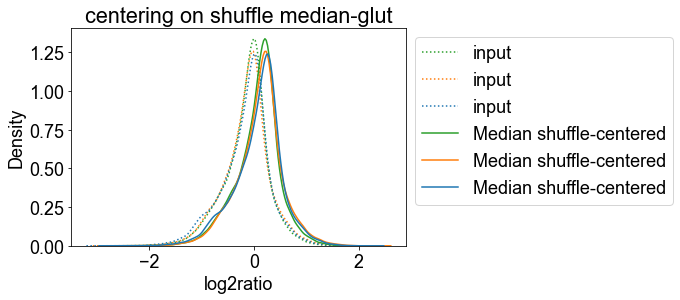



 after centering 

         ctrl sample_id    count       50%       std
0   negative    glut_1    205.0 -0.684462  0.304968
1   negative    glut_2    207.0 -0.580959  0.258853
2   negative    glut_3    205.0 -0.574380  0.298338
3   positive    glut_1    127.0  0.411562  0.207915
4   positive    glut_2    127.0  0.344512  0.202995
5   positive    glut_3    127.0  0.357924  0.242676
6    shuffle    glut_1    179.0  0.000000  0.367824
7    shuffle    glut_2    183.0  0.000000  0.388767
8    shuffle    glut_3    178.0  0.000000  0.401547
9       test    glut_1  35637.0  0.156352  0.465378
10      test    glut_2  35599.0  0.128585  0.424445
11      test    glut_3  35317.0  0.151074  0.449810
z-score
n sequences w/ <3 replicates removed, n= 0
log2ratio_centered
n sequences w/ <3 replicates removed, n= 0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(125074, 19) (110168, 19) removed tags w/ <10 barcodes N= 14906
gaba 

 before centering 

         ctrl sample_id    count       50%       std
0   negative    gaba_1    209.0 -1.518982  0.309172
1   negative    gaba_2    210.0 -1.498370  0.328632
2   negative    gaba_3    209.0 -1.485085  0.296023
3   positive    gaba_1    127.0  0.633998  0.127930
4   positive    gaba_2    127.0  0.640488  0.142543
5   positive    gaba_3    127.0  0.639488  0.137168
6    shuffle    gaba_1    184.0 -0.283298  0.664044
7    shuffle    gaba_2    184.0 -0.310470  0.671824
8    shuffle    gaba_3    183.0 -0.294778  0.669228
9       test    gaba_1  36168.0 -0.065723  0.684488
10      test    gaba_2  36229.0 -0.069030  0.679871
11      test    gaba_3  36211.0 -0.060113  0.681966


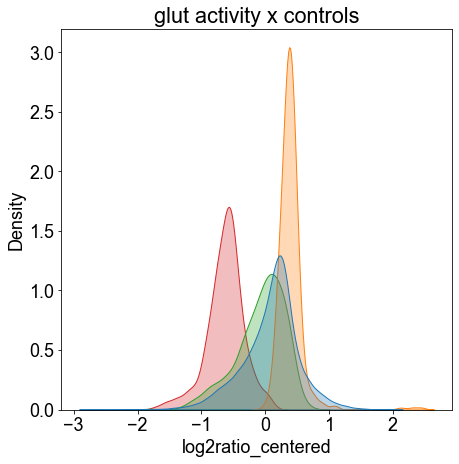

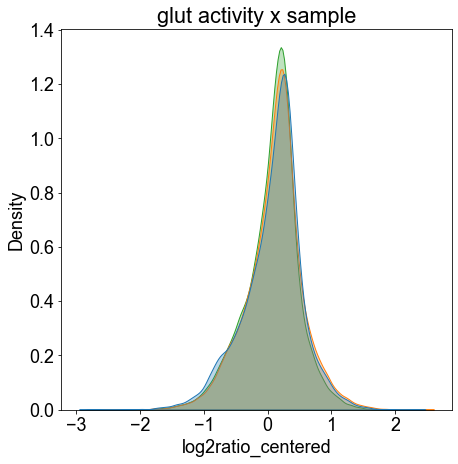

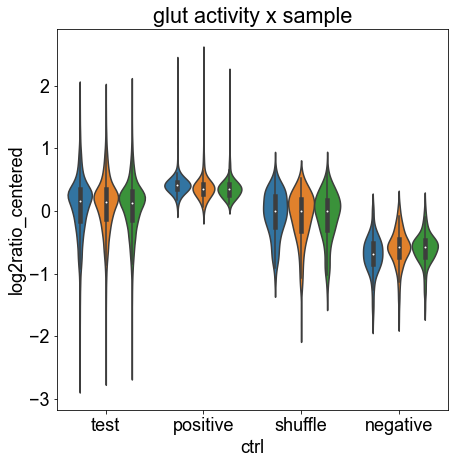

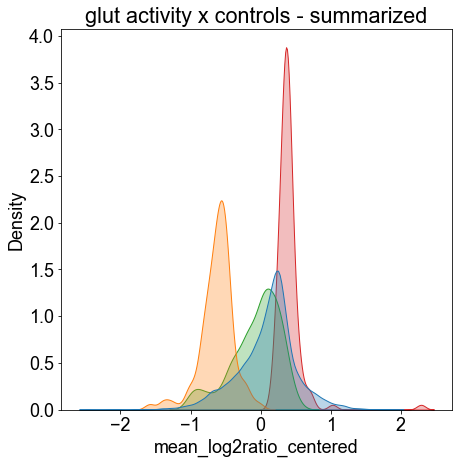

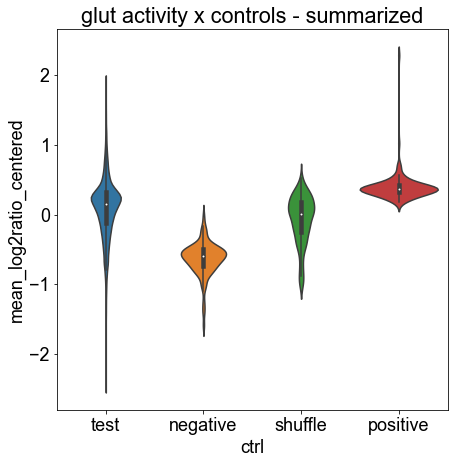

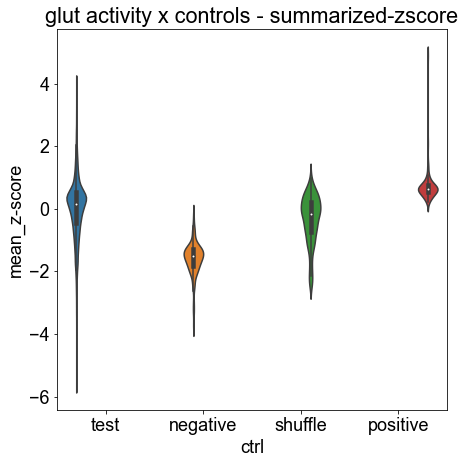

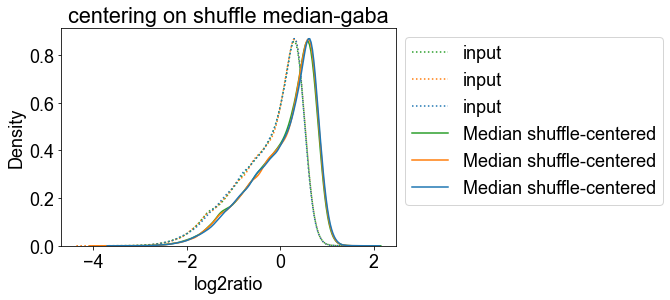



 after centering 

         ctrl sample_id    count       50%       std
0   negative    gaba_1    209.0 -1.235684  0.309172
1   negative    gaba_2    210.0 -1.187900  0.328632
2   negative    gaba_3    209.0 -1.190307  0.296023
3   positive    gaba_1    127.0  0.917296  0.127930
4   positive    gaba_2    127.0  0.950958  0.142543
5   positive    gaba_3    127.0  0.934266  0.137168
6    shuffle    gaba_1    184.0  0.000000  0.664044
7    shuffle    gaba_2    184.0  0.000000  0.671824
8    shuffle    gaba_3    183.0  0.000000  0.669228
9       test    gaba_1  36168.0  0.217575  0.684488
10      test    gaba_2  36229.0  0.241440  0.679871
11      test    gaba_3  36211.0  0.234665  0.681966
z-score
n sequences w/ <3 replicates removed, n= 0
log2ratio_centered
n sequences w/ <3 replicates removed, n= 0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


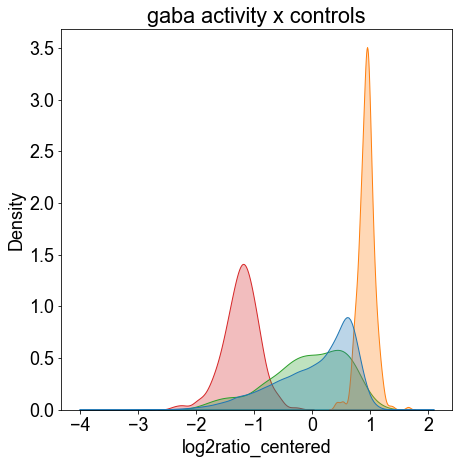

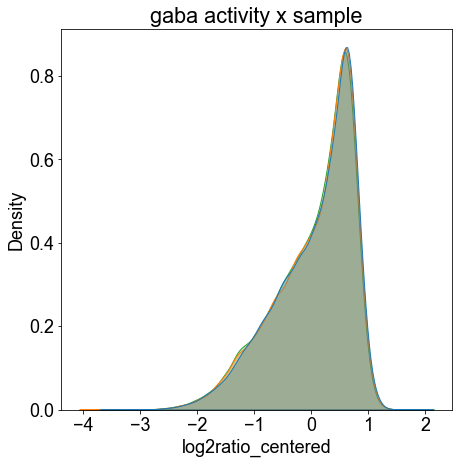

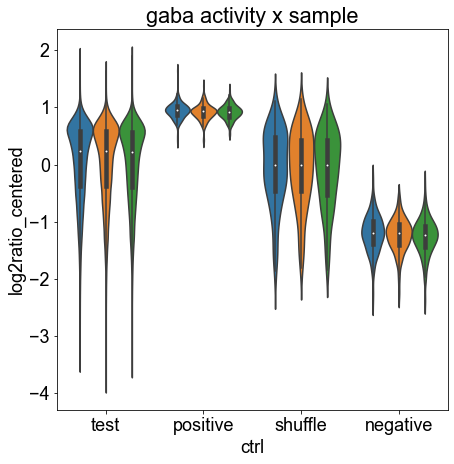

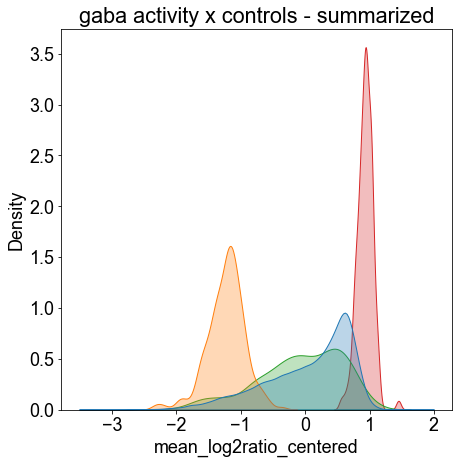

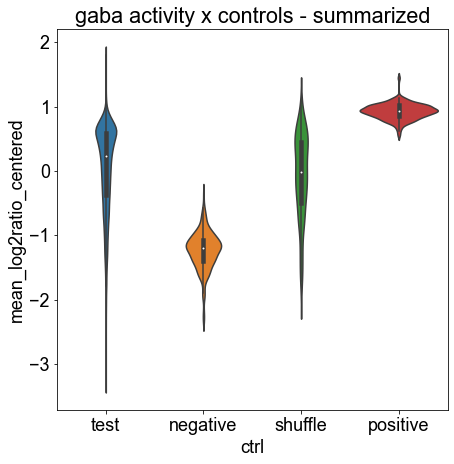

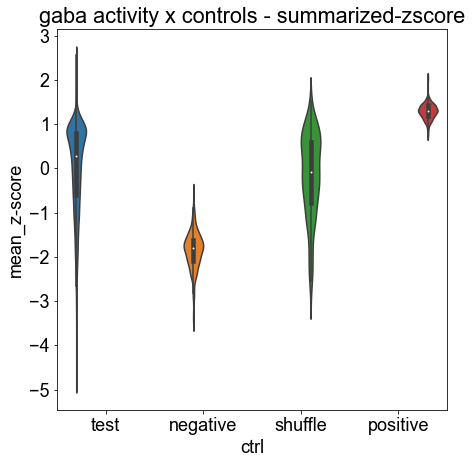

In [7]:
cleaned_reps, summ_act = {}, {}
PLOT = True
for cell_type, files in RUNS.items():
    """
    1. open replicate as pd dataframe
    2. filter out sequences with < 10 barcodes
    3. comput the 
    """

    df = listToDf(files, section)  # make df

    clean_df = removeTags(df, MIN_TAGS)  # clean df for min tags
    clean_df["ctrl"] = clean_df["ctrl"].fillna("test")

    # compute medians per replicate
    desc_act, desc_tag, medians = ctrlMedians(
        clean_df, "log2ratio")  
    
    # summarize activity across replicates before centering
    print(cell_type,
          "\n\n before centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%", "std"]])
    
    # center values on median of shuffle, or z-score
    clean_df = centerOnShufMed(clean_df, medians)

    desc_act, desc_tag, medians = ctrlMedians(
        clean_df, "log2ratio_centered")  # compute medians

    print("\n\n after centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%", "std"]])  # describe activity across replicates

    # add replicate data to dictionary
    cleaned_reps[cell_type] = clean_df

    ### summarize activity across replicates ###

    sum_df = meanRatio(clean_df)
    
    # add summarized data to dictionary
    summ_act[cell_type] = sum_df
    
    if PLOT is True:
        
        ### plot replicate data ###
        x = "log2ratio_centered"
        data = clean_df
        hue = "ctrl"
        
        title = f"{cell_type} activity x controls"
        kdeplot(x, data, hue, title)

        hue = "sample_id"
        title = f"{cell_type} activity x sample"
        kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "log2ratio_centered"
        hue = "sample_id"
        violinplot(x, y, data, hue, title)

        ### plot summarized data ###
        x = "mean_log2ratio_centered"
        data = sum_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls - summarized"
        kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "mean_log2ratio_centered"
        hue = None
        violinplot(x, y, data, hue, title)
        
        x = "ctrl"
        y = "mean_z-score"
        data = sum_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls - summarized-zscore"
        violinplot(x, y, data, hue, title)



## combine replicate glut and gaba data

In [8]:
clean_df = pd.concat(cleaned_reps.values())
clean_df.head()

,name,RNA,DNA,ratio,tags,sample_id,celltype,sequence,bkgd,h,...,coor,top_bottom,strand,#chr,start,end,log2ratio,log2ratio_shufmedian,log2ratio_centered,z-score
0,chr7:87345167-87345437,0.231252,0.205155,1.127204,35,glut_1,glut,AGGACCGGATCAACTAGTGTTCGCCTGGTGCTGCAAAAAGCGGCTC...,False,NaN,...,chr7:87345167-87345437,NaN,+,chr7,87345167.0,87345437,0.172748,-0.24233,0.415078,0.735984
1,chr2:20651352-20651622,0.531078,0.528442,1.004988,111,glut_1,glut,AGGACCGGATCAACTGTGTGTCTGTTTTGCGCTAAAGTTTAGCCGT...,False,NaN,...,chr2:20651352-20651622,NaN,+,chr2,20651352.0,20651622,0.007178,-0.24233,0.249508,0.367460
2,chr2:135029394-135029664,0.239563,0.272767,0.878270,104,glut_1,glut,AGGACCGGATCAACTCAAAAAAACATTAGATTACAATTACAACTGC...,False,NaN,...,chr2:135029394-135029664,NaN,+,chr2,135029394.0,135029664,-0.187263,-0.24233,0.055067,-0.065326
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,0.134965,0.302686,0.445891,71,glut_1,glut,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.165237,-0.24233,-0.922907,-2.242089
4,chr18:48667793-48668063,0.898362,0.528138,1.700997,72,glut_1,glut,AGGACCGGATCAACTCACTAGCCAAAGCCTGTCACTCCCAGGTTCC...,False,NaN,...,chr18:48667793-48668063,NaN,+,chr18,48667793.0,48668063,0.766381,-0.24233,1.008711,2.057285


## evaluate replicate z-score distribution
- shuffled distribution is shifted for GABA, but this should not matter for calling categorical activity, as categorical activity is relative to the 95% of shuffled distribution within that cell type.

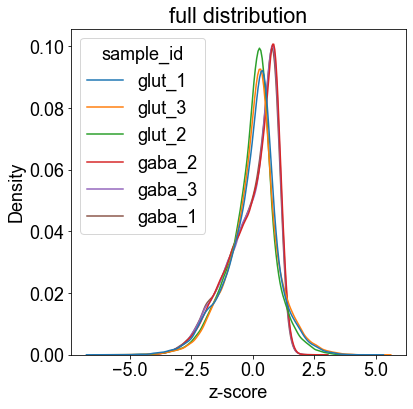

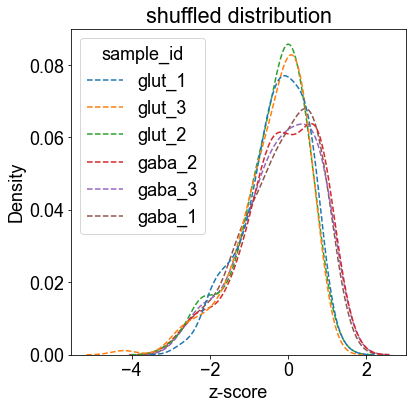

In [29]:
plotting = clean_df[["name", "sample_id", "z-score", "celltype"]].drop_duplicates().copy().reset_index()
fig, ax=plt.subplots(figsize=(6,6))
sns.kdeplot(x="z-score", data=plotting, hue='sample_id')
plt.title("full distribution")
plt.savefig(os.path.join(RE, "reps_zscore_full_distribution.pdf"))

fig, ax=plt.subplots(figsize=(6,6))
sns.kdeplot(x="z-score", data=plotting.loc[plotting["name"].str.contains("shuffle")], hue='sample_id', ls ="--")
plt.title("shuffled distribution")
plt.savefig(os.path.join(RE, "reps_zscore_shuffled_distribution.pdf"))

## P-value

In [27]:
# reduce dataframe for computing p-values
cols = ["name", "sample_id", "celltype", "z-score"]
test = clean_df[cols].drop_duplicates()
test.head()

,name,sample_id,celltype,z-score
0,chr7:87345167-87345437,glut_1,glut,0.735984
1,chr2:20651352-20651622,glut_1,glut,0.367460
2,chr2:135029394-135029664,glut_1,glut,-0.065326
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,glut_1,glut,-2.242089
4,chr18:48667793-48668063,glut_1,glut,2.057285


In [37]:
# pivot table to compute row-wise p-values
rep_table = pd.pivot(test, index="name", columns ="sample_id", values="z-score").reset_index()
print(rep_table.shape[0])
rep_table=rep_table.dropna()  # drop duplicates
print(rep_table.shape[0])
rep_table.head()

37039
35371


sample_id,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420
5,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946


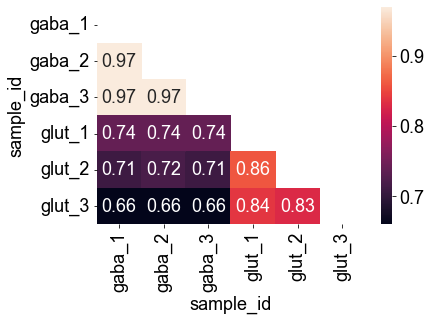

In [261]:
corr=rep_table[rep_table.columns[1:-1]].corr().round(2)

corr_= corr.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_)

sns.heatmap(corr, annot=True, mask=matrix)
plt.savefig(os.path.join(RE, "rep_corr.pdf"),bbox_inches="tight")

In [38]:
# compute p-value
rep_table = computePval(rep_table, rep_table.columns[1:])

In [264]:
rep_table["-log10p"] = -1*(np.log10(rep_table["pval"].astype(float)))

rep_table.to_csv(SIG_ACTIVITY_Z, sep='\t', index=False)
rep_table.head()

sample_id,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.0371073,1.430540
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,0.442415
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,0.202999
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,0.632257
5,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,0.142693


Text(0.5, 1.0, 'GABA v. GLUT replicates\np distribution')

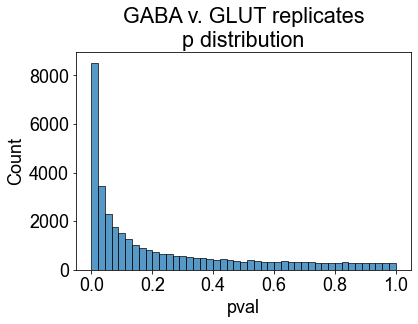

In [49]:
sns.histplot(rep_table["pval"])
plt.title("GABA v. GLUT replicates\np distribution")


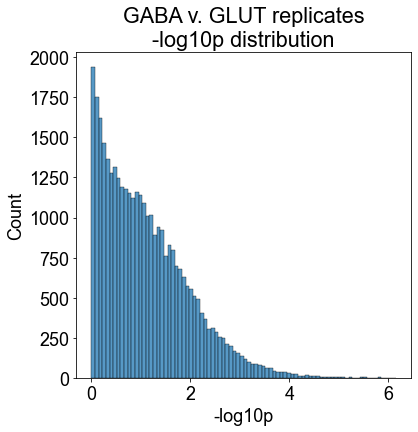

In [262]:
fig, ax= plt.subplots(figsize=(6,6))

sns.histplot(rep_table["-log10p"])
plt.title("GABA v. GLUT replicates\n-log10p distribution")
plt.savefig(os.path.join(RE, "pval_dist.pdf"),bbox_inches="tight")

## q-q plot is right skewed. 

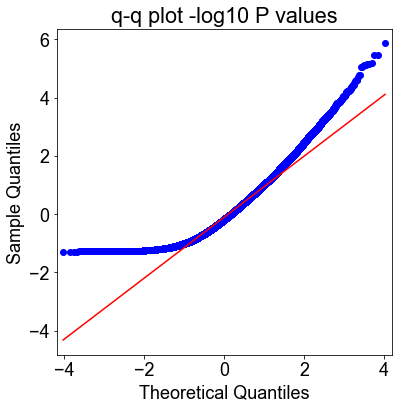

In [68]:
import pylab 
import statsmodels.api as sm

fig, ax= plt.subplots(figsize=(6,6))
measurements = rep_table["-log10p"]
sm.qqplot(measurements, line='q',ax=ax, fit=True)
ax.set(title="q-q plot -log10 P values")
pylab.show()

## check shuffles - MWU

In [69]:
sum_df = pd.concat(summ_act.values()).drop_duplicates()  # concatenate gaba and glut clean reps
sum_df.head()

,name,coor,strand,ctrl,celltype,mean_z-score,mean_log2ratio_centered
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.696544,-0.677805
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.740263,-0.697447
6,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.842682,-0.743462
9,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.554678,-0.614067
12,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-2.505154,-1.041096


In [70]:
pd.merge(sum_df, rep_table[['name', "pval"]], how="left")

,name,coor,strand,ctrl,celltype,mean_z-score,mean_log2ratio_centered,pval
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.696544,-0.677805,0.0371073
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.740263,-0.697447,0.361064
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.842682,-0.743462,0.626615
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-1.554678,-0.614067,0.233208
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",NaN,NaN,test,glut,-2.505154,-1.041096,0.719958
...,...,...,...,...,...,...,...,...
71794,shuffle_95_chr19:13408968-13409238,shuffle_95_chr19:13408968-13409238,+,shuffle,gaba,0.265764,0.223373,0.0689959
71795,shuffle_96_chr13:58618367-58618637,shuffle_96_chr13:58618367-58618637,+,shuffle,gaba,0.200112,0.178189,0.353369
71796,shuffle_97_chr9:32573222-32573492,shuffle_97_chr9:32573222-32573492,+,shuffle,gaba,-0.362111,-0.208750,NaN
71797,shuffle_98_chr3:12869018-12869288,shuffle_98_chr3:12869018-12869288,+,shuffle,gaba,-0.385766,-0.225030,0.39833


In [30]:
shufs.head()

,index,name,coor,strand,ctrl,celltype,mean_z-score,mean_log2ratio_centered
0,3120,Negative-GLUT_shuffle163_chr2:172234903-172235...,Negative-GLUT_shuffle163_chr2:172234903-172235...,-,shuffle,glut,-1.079547,-0.400401
1,3123,Negative-GLUT_shuffle30_chr2:199552111-1995523...,Negative-GLUT_shuffle30_chr2:199552111-1995523...,-,shuffle,glut,-1.444267,-0.564204
2,3534,Negative-shuffle116_chr2:171661323-171661592:+,Negative-shuffle116_chr2:171661323-171661592:+,+,shuffle,glut,-1.874829,-0.757579
3,3537,Negative-shuffle137_chr12:44592567-44592836:+,Negative-shuffle137_chr12:44592567-44592836:+,+,shuffle,glut,-2.428067,-1.006050
4,3540,Negative-shuffle157_chr18:59505385-59505654:-,Negative-shuffle157_chr18:59505385-59505654:-,-,shuffle,glut,-1.558689,-0.615593


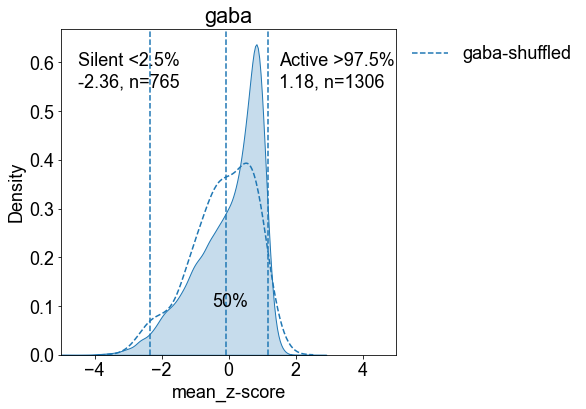

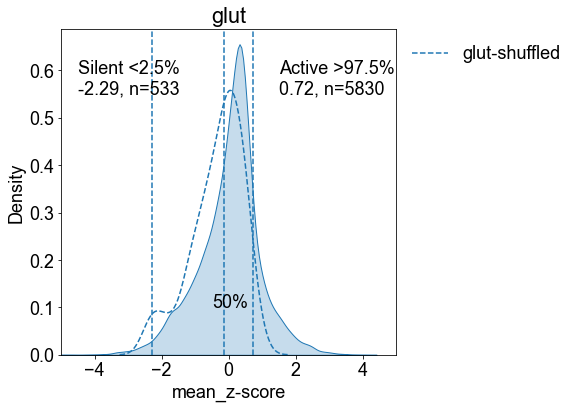

In [126]:
col = "mean_z-score"

test = sum_df.loc[sum_df["ctrl"].str.contains("test")].reset_index()
shufs = sum_df.loc[sum_df["name"].str.contains("shuffle")].reset_index()

celltypes = ["gaba", "glut"]
for cell in celltypes:
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_shuf = shufs.loc[shufs["celltype"] == cell]
    plot_test = test.loc[test["celltype"] == cell]
    
    # get quantiles
    median_ci=shufs.loc[shufs["celltype"] == cell, col].quantile(0.5).round(2)
    high_ci=shufs.loc[shufs["celltype"] == cell, col].quantile(0.975).round(2)
    low_ci=shufs.loc[shufs["celltype"] == cell, col].quantile(0.025).round(2)
    active = plot_test.loc[plot_test[col]>high_ci].shape[0]
    silent = plot_test.loc[plot_test[col]<low_ci].shape[0]

    # plot shuffled distribution of activity scores
    sns.kdeplot(x=col, data=plot_shuf, label="shuf",
                hue="celltype", ls="--", ax=ax, )
    
    # plot full distribution of activity scores
    sns.kdeplot(x=col, data=plot_test, label="data",
                hue="celltype", ax=ax, fill=True)

    ax.axvline(median_ci, ls="--", )
    ax.axvline(high_ci, ls="--", )
    ax.axvline(low_ci, ls="--", )
    ax.text(-4.5, 0.55, f"Silent <2.5%\n{low_ci}, n={silent}")
    ax.text(-0.5, 0.1, "50%")
    ax.text(1.5, 0.55, f"Active >97.5%\n{high_ci}, n={active}")
    ax.set(xlim=(-5,5), 
          title=cell)
    ax.legend([f"{cell}-shuffled"], bbox_to_anchor=(1,1), frameon=False)

    plt.savefig(os.path.join(RE, f"distribution.meanzscore.{cell}.pdf"), bbox_inches='tight')

check replicates, barcode number, standard scaling

- talk to chengyu and gina

tags MannwhitneyuResult(statistic=139930.5, pvalue=0.04467950347004362)
log2ratio MannwhitneyuResult(statistic=148169.0, pvalue=0.4540625832872932)
log2ratio_centered MannwhitneyuResult(statistic=139778.0, pvalue=0.04199588131406084)
z-score MannwhitneyuResult(statistic=128865.0, pvalue=6.532421873838724e-05)


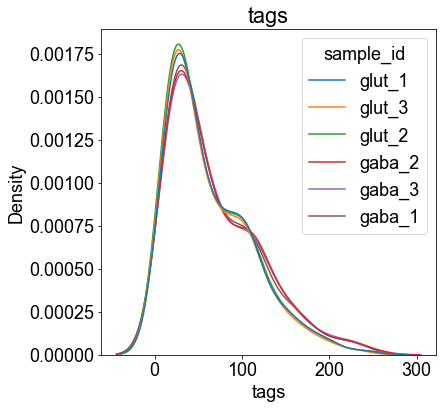

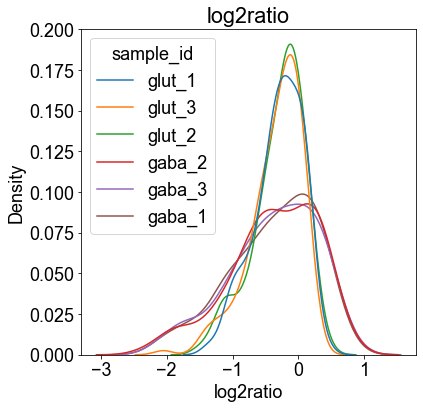

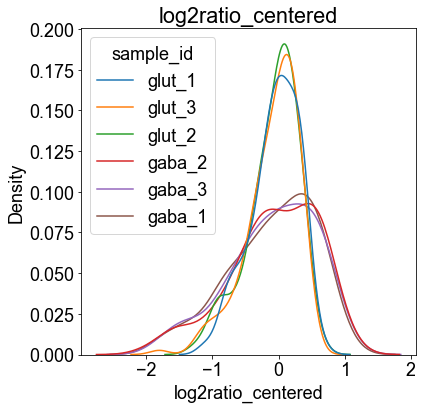

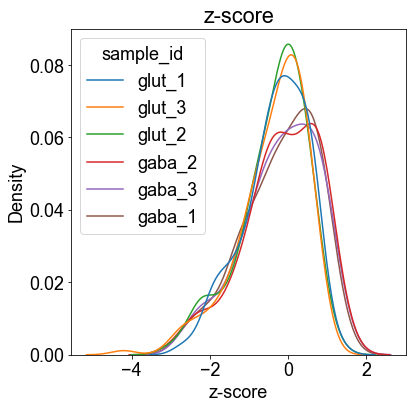

In [128]:
clean_df = pd.concat(cleaned_reps.values()).drop_duplicates()  # concatenate gaba and glut clean reps

cols = ["tags", "log2ratio", "log2ratio_centered", "z-score"]
clean_shuf = clean_df.loc[clean_df["ctrl"] =="shuffle"]
for col in cols:
    gaba_series = list(clean_shuf.loc[clean_shuf['celltype']=="gaba", col])
    glut_series = list(clean_shuf.loc[clean_shuf['celltype']=="glut", col])
    print(col, stats.mannwhitneyu(gaba_series, glut_series ))

    fig, ax= plt.subplots(figsize =(6,6))
    
    sns.kdeplot(x=col, data=clean_shuf, hue="sample_id")
    ax.set(title=col)

In [133]:
import statsmodels.formula.api as smf
sm.add_constant(clean_df)
results = smf.ols('log2ratio ~ sample_id + celltype + tags', data=clean_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log2ratio   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1101.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:15:25   Log-Likelihood:            -1.8929e+05
No. Observations:              218259   AIC:                         3.786e+05
Df Residuals:                  218252   BIC:                         3.787e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3473    

# compare cell type specific activity

 DO STRAND another time

In [134]:
def labelStrand(df_, celltype):
    df = df_.loc[df_["name"].str.contains("chr")]

    print(df.shape)
    
    df = pd.pivot(df, index="coor", columns="strand",
                  values='active').reset_index()
    df[f"n.active.strands.{celltype}"] = df["+"] + df["-"]

    return df

In [137]:
# make joint df
celltypes = {"glut": None, "gaba": None}

for celltype in celltypes.keys():
    print(celltype)

    cell_df = summ_act[celltype]  # get summary dataframe

    # label categorical activity
    cell_df = labelActive(cell_df, dif_col, celltype)

    # add to dictionaries
    # update the dataframe
    celltypes[celltype] = cell_df

glut
mean_z-score shuf top 97.5% = 0.72 shuf bottom 2.5% = -2.31
gaba
mean_z-score shuf top 97.5% = 1.19 shuf bottom 2.5% = -2.38


## joint activity

In [138]:
cols = ['name', "celltype", dif_col,"active"]
joint_activity = pd.concat((celltypes["glut"][cols], 
                            celltypes["gaba"][cols])
                         ).drop_duplicates()
joint_activity

# call differential activity

In [174]:
joint_activity = pd.merge(joint_activity, rep_table[["name", "pval", '-log10p']])#.drop_duplicates().shape
joint_activity["sig"] = False
joint_activity.loc[joint_activity["pval"]<0.05, "sig"] = True

In [175]:
activity = pd.pivot(joint_activity, index="name",
        columns='celltype', 
        values=dif_col).reset_index().dropna().drop_duplicates()

activity = pd.merge(activity, joint_activity[['name', "sig"]]).drop_duplicates()

labels = pd.pivot(joint_activity, index="name",
        columns='celltype', 
        values='active').reset_index().dropna()

labels = pd.merge(labels, joint_activity[['name', "sig"]]).drop_duplicates()

## significant, cell-type-specific MPRA activtiy counts

In [177]:
sig = labels.sort_values(by='sig', ascending=False).groupby(["sig", "gaba", "glut", ])["name"].count().reset_index()
sig

,sig,gaba,glut,name
0,False,False,False,19039
1,False,False,activating,2561
2,False,False,silencing,141
3,False,activating,False,101
4,False,activating,activating,365
5,False,silencing,False,229
6,False,silencing,silencing,276
7,True,False,False,8939
8,True,False,activating,2623
9,True,False,silencing,98


0 2623.0 0.8 -0.4
0 98.0 0.8 0.6
0 567.0 0.8 1.6
0 317.0 0.8 2.6
0 97.0 0.8 3.6
0 1.0 0.8 4.6
0 17.0 0.8 5.6


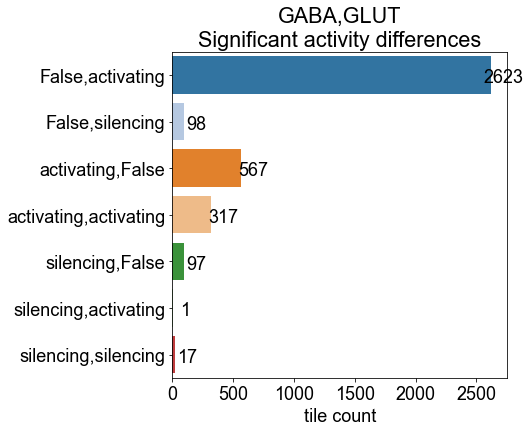

In [232]:
x = 'gaba,glut'
y = "name"
sig[x] = sig["gaba"].map(str) + "," + sig["glut"].map(str)

plot_data = sig.loc[(sig.sig == True)
                    & (sig[x] != "False,False")]

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=y, y=x,
            data=plot_data, 
            palette="tab20"
            )
# show the mean
for p in ax.patches:

    h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
    print(x, w, h, y)
    xy = (w+100, y+0.45)

    ax.annotate(text=int(w), xy=xy, ha='center', va='center')
ax.set(xlabel="tile count", 
       title="GABA,GLUT\nSignificant activity differences", 
      ylabel = "")

plt.savefig(os.path.join(RE, "sig.activitydif.counts.pdf"), bbox_inches="tight")

## dif activity 
- Note: labels are not the same

In [233]:
labels['celltype_dif'] = False

labels.loc[labels["gaba"]!=labels["glut"], "celltype_dif"] = True
labels = labels.rename(columns={"gaba": "gaba-label", "glut": "glut-label"})

dif_activity = labels.groupby(["sig", "celltype_dif"]).count().reset_index()

dif_activity

### how many are statistically significant and categorically differentially active? 

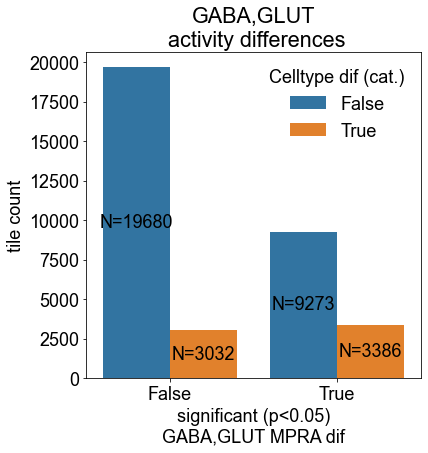

In [255]:
x = "sig"
y="name"
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=x, y=y, data= dif_activity, hue="celltype_dif")

ax.set(ylabel="tile count", 
       title="GABA,GLUT\n activity differences", 
      xlabel = "significant (p<0.05)\nGABA,GLUT MPRA dif")

# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'N={int(h)}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')
ax.legend(title="Celltype dif (cat.)", frameon=False)

plt.savefig(os.path.join(RE, "activitydif.counts.pdf"), bbox_inches="tight")

## 9.6% of tiles have categorical activity differences and significant activity differences. 

In [172]:
3386/35371

0.09572813887082639

## add differential activity information to the column

In [265]:
activity = pd.merge(activity, labels[["name", 'celltype_dif']], how="left")
activity["delta.gaba-glut"] = activity['gaba'] - activity["glut"]

activity = pd.merge(labels, activity)
activity = pd.merge(activity, rep_table[["name", "pval", "-log10p"]]).drop_duplicates()
activity.dropna().shape #35371

(35371, 10)

## Write delta activity

In [266]:
activity.to_csv(delta_file, sep='\t', index=False)
activity.head()

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,pval,-log10p
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,True,True,-2.699699,-1.696544,-1.003154,0.0371073,1.430540
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.361064,0.442415
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.626615,0.202999
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.233208,0.632257
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.719958,0.142693


## activating in gaba, not active in glut

In [267]:
activity.loc[(activity["gaba-label"]=="activating")&
            (activity['glut-label']!="False")&
            (activity["celltype_dif"]==True)
            &(activity["pval"]<0.05)].sort_values(by='delta.gaba-glut', ascending=False)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,pval,-log10p
2135,chr10:32056179-32056449,activating,False,True,True,1.192355,-0.985470,2.177825,0.035506,1.449699
7955,chr14:105162488-105162758,activating,False,True,True,1.204357,-0.509433,1.713791,4.17963e-05,4.378862
15602,chr1:22710262-22710532,activating,False,True,True,1.394172,-0.155738,1.549909,0.0012897,2.889511
7954,chr14:105162468-105162738,activating,False,True,True,1.188597,-0.343674,1.532271,0.00728484,2.137580
10170,chr15:99251663-99251933,activating,False,True,True,1.476523,-0.037601,1.514125,0.0372697,1.428644
...,...,...,...,...,...,...,...,...,...,...
28389,chr5:58143499-58143769,activating,False,True,True,1.207177,0.705719,0.501458,0.0445115,1.351528
17533,chr20:19492790-19493060,activating,False,True,True,1.187353,0.693706,0.493647,0.0264214,1.578044
26087,chr4:61640344-61640614,activating,False,True,True,1.199722,0.709707,0.490015,0.0133632,1.874088
5670,chr12:15363963-15364233,activating,False,True,True,1.198911,0.709941,0.488969,0.000933422,3.029922


## activating in glut, not active in gaba

In [271]:
activity.loc[(activity["gaba-label"]!="False")&
            (activity['glut-label']=="activating")&
            (activity["celltype_dif"]==True)&
            (activity["pval"]<0.05)].sort_values(by='delta.gaba-glut', ascending=True)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,pval,-log10p
29980,chr6:154127563-154127833,False,activating,True,True,-0.728135,2.914324,-3.642459,0.0048831,2.311304
29981,chr6:154127583-154127853,False,activating,True,True,-0.387155,3.235735,-3.622891,0.000408811,3.388478
16229,chr1:31376876-31377146,False,activating,True,True,-0.785451,2.687121,-3.472572,0.00603443,2.219363
18752,chr21:37366535-37366805,False,activating,True,True,0.387940,3.711911,-3.323971,0.0019132,2.718239
29983,chr6:154127623-154127893,False,activating,True,True,-0.253366,3.044297,-3.297663,0.000602315,3.220177
...,...,...,...,...,...,...,...,...,...,...
22482,chr2:48699383-48699653,False,activating,True,True,1.139102,0.723789,0.415314,0.00946525,2.023868
21197,chr2:175889490-175889760,False,activating,True,True,1.166403,0.742426,0.423977,0.0171272,1.766315
6358,chr12:49201870-49202140,False,activating,True,True,1.170067,0.741843,0.428224,0.0286213,1.543311
28564,chr5:72608213-72608483,False,activating,True,True,1.161925,0.731824,0.430101,0.0296151,1.528487


## silencing in gaba, activating in glut

In [272]:
activity.loc[(activity["gaba-label"]=="silencing")&
            (activity['glut-label']=="activating")&
            (activity["celltype_dif"]==True)&
            (activity["pval"]<0.05)]

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,pval,-log10p
14321,chr1:10339772-10340042,silencing,activating,True,True,-2.387626,0.850864,-3.23849,0.0476004,1.322389


## commonly activating

In [273]:
activity.loc[(activity["gaba-label"]=="activating")&
            (activity['glut-label']=="activating")&
            (activity["celltype_dif"]==False)&
            (activity["pval"]<0.05)].sort_values(by='delta.gaba-glut', ascending=True)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,pval,-log10p
1186,Positive-GABA_72hr_top_4,activating,activating,True,False,2.047256,4.906244,-2.858988,0.000632557,3.198900
4152,chr11:45288365-45288635,activating,activating,True,False,1.228760,3.378958,-2.150197,0.0259893,1.585206
31154,chr7:100489890-100490160,activating,activating,True,False,1.287616,3.421696,-2.134080,1.52705e-05,4.816146
18980,chr21:46144023-46144293,activating,activating,True,False,1.408826,3.509183,-2.100357,0.000114408,3.941543
5056,chr12:109573435-109573705,activating,activating,True,False,1.225626,3.310861,-2.085235,0.000342594,3.465220
...,...,...,...,...,...,...,...,...,...,...
1199,Positive-GABA_chr12:44257591-44257860:+,activating,activating,True,False,1.532330,0.775367,0.756963,0.00886226,2.052455
33236,chr9:100205048-100205318,activating,activating,True,False,1.556358,0.794497,0.761861,0.000360046,3.443642
6851,chr12:8692713-8692983,activating,activating,True,False,1.495133,0.732100,0.763034,0.0287667,1.541111
35336,shuffle_5_chr21:10272390-10272660,activating,activating,True,False,1.519341,0.732905,0.786436,0.000773228,3.111692


## commonly silencing

In [274]:
activity.loc[(activity["gaba-label"]=="silencing")&
            (activity['glut-label']=="silencing")&
            (activity["celltype_dif"]==False)&
            (activity["pval"]<0.05)].sort_values(by='delta.gaba-glut', ascending=True)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,pval,-log10p
18542,chr21:25734941-25735211,silencing,silencing,True,False,-3.777996,-2.574176,-1.203820,0.0318067,1.497481
20117,chr2:127281204-127281474,silencing,silencing,True,False,-3.537087,-2.767433,-0.769654,0.0106975,1.970716
28812,chr6:101393607-101393877,silencing,silencing,True,False,-3.143136,-2.434011,-0.709126,0.0480525,1.318284
15216,chr1:178094572-178094842,silencing,silencing,True,False,-3.380966,-2.703622,-0.677343,0.0359711,1.444046
32869,chr8:30638525-30638795,silencing,silencing,True,False,-3.106228,-2.475129,-0.631099,0.00571402,2.243058
15213,chr1:178094512-178094782,silencing,silencing,True,False,-3.229282,-2.671428,-0.557854,0.0495319,1.305115
19863,chr22:46894721-46894991,silencing,silencing,True,False,-2.903211,-2.378670,-0.524541,0.0314958,1.501748
29765,chr6:129584060-129584330,silencing,silencing,True,False,-3.241661,-2.805301,-0.436360,0.0255681,1.592302
16938,chr1:72623099-72623369,silencing,silencing,True,False,-2.916954,-2.561820,-0.355134,0.0336316,1.473252
6387,chr12:51590645-51590915,silencing,silencing,True,False,-2.607560,-2.976695,0.369135,0.0325414,1.487563


## full distribution - delta gaba-glut

<AxesSubplot:xlabel='delta.gaba-glut', ylabel='Count'>

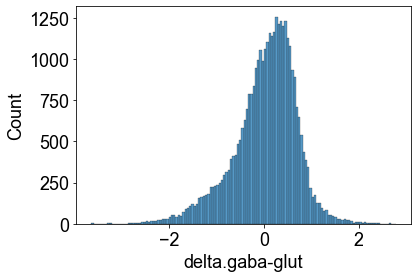

In [275]:
sns.histplot(activity["delta.gaba-glut"])

## joint plot - glut v. gaba

[Text(0.5, 1.0, 'MPRA activity\nmean_z-score'), (-6.0, 6.0), (-6.0, 6.0)]

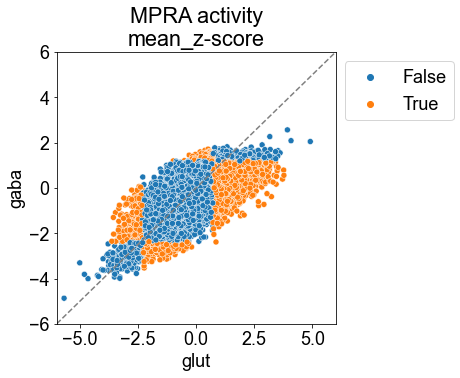

In [276]:
x = 'glut'
y = 'gaba'
hue ="celltype_dif"
data = activity
size = (-6,6)

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=x, y=y, data=data,hue=hue)
plt.plot(size,size, ls = "--", color="grey")
ax.legend(bbox_to_anchor=(1,1))
ax.set(title=f"MPRA activity\n{dif_col}",
      ylim=size,xlim=size)

## pearson correlation between cell types

### all data - Gaba v. Glut

In [277]:
stats.pearsonr(data[x], data[y])

(0.751362842022575, 0.0)

### shuffles only

In [278]:
vals = ["shuf", "Positive", "Negative", "72"]
for val in vals:

    subset= data.loc[data["name"].str.contains(val)]
    print(val, stats.pearsonr(subset[x], subset[y]))

shuf (0.8628272072365781, 9.864770679375349e-54)
Positive (0.3913174150487023, 4.940209107528409e-06)
Negative (0.7730691867577504, 3.4746681277365556e-44)
72 (0.7756924344510445, 0.0)


## how many celltype-specific active?

 2x2 celltype specific coors enriched for strand-specific effects?
 
     - a = n coordinates with cell type AND strand-specific
     - b = n coordinates with cell type NOT strand-specific
     - c = n coordinates NOT cell type specific AND strand-specific
     - d = n coordinates NOT cell type NOT strand-specific
     
        ss +     ss-
    cs +   A.       B
    cs -   C.       D

## Do FET

In [ ]:
from scipy.stats import fisher_exact

#fisher_exact([[a,b],[c,d]])